# EDA **********************

## [1] 준비작업

### 데이터 불러오기

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [272]:
df = pd.read_csv("final.csv")
df.drop("Unnamed: 0", axis = 1, inplace = True)

In [273]:
df.head(2)

,channelId,channelTitle,videoId,duration,viewCount,paidBadge,bday,subs,gender,prettyScale,publishedAt,videoTitle,desc,tag
0,UCT-_4GqC-yLY1xtTHhwY0hA,PONY Syndrome,z0MKkIdcq8g,59,113589,1,3393,5930000,F,83.75,218,Which look is your fav?🧚🏻‍♀️🍄🎀,NaN,NaN
1,UCT-_4GqC-yLY1xtTHhwY0hA,PONY Syndrome,NhxLyUKp4VA,39,175305,1,3393,5930000,F,83.75,185,3D Juicy Lips Tutorial🍒,#광고 \n\n3D Juicy Lips Tutorial with \n@somethi...,NaN


In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2186 entries, 0 to 2185
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   channelId     2186 non-null   object 
 1   channelTitle  2186 non-null   object 
 2   videoId       2186 non-null   object 
 3   duration      2186 non-null   int64  
 4   viewCount     2186 non-null   int64  
 5   paidBadge     2186 non-null   int64  
 6   bday          2186 non-null   int64  
 7   subs          2186 non-null   int64  
 8   gender        2186 non-null   object 
 9   prettyScale   2186 non-null   float64
 10  publishedAt   2186 non-null   int64  
 11  videoTitle    2186 non-null   object 
 12  desc          1415 non-null   object 
 13  tag           942 non-null    object 
dtypes: float64(1), int64(6), object(7)
memory usage: 239.2+ KB


In [275]:
# 조회수, 구독자 로그화 컬럼 추가

import numpy as np

df['viewCount_log'] = df['viewCount'].apply(np.log1p)
df['subs_log'] = df['subs'].apply(np.log1p)

In [276]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 일 평균 조회수 컬럼 추가

* 조회수는 누적값이라 게시 기간이 늘어날수록 조회수도 따라서 늘어남 (횡보할 수는 있어도 줄어들 수는 없음)
* 모델링의 경우 **게시 기간에 따라 예측 조회수를 확인**할 수 있도록 게시 기간 컬럼을 따로 설정하여 모델링을 할 예정
* 지금은 변수 사이의 상관관계를 분석하기 위해 영상별 조회수를 게시 일수로 나누어 **일 평균 조회수 컬럼**을 새로 추가하고자 함

In [281]:
# 일 평균 조회수 컬럼 추가

df['viewCount_avg'] = df['viewCount'] / df['publishedAt']

In [282]:
(df['viewCount_avg'] < 1).value_counts()

viewCount_avg
False    2147
True       37
Name: count, dtype: int64

In [283]:
df['viewCount_avg'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['viewCount_avg'].fillna(0, inplace=True)

In [284]:
(df['viewCount_avg'] == 0).value_counts()

viewCount_avg
False    2180
True        4
Name: count, dtype: int64

In [285]:
df['viewCount_avg'] = df['viewCount_avg'].apply(round)

<Axes: xlabel='viewCount_avg', ylabel='Count'>

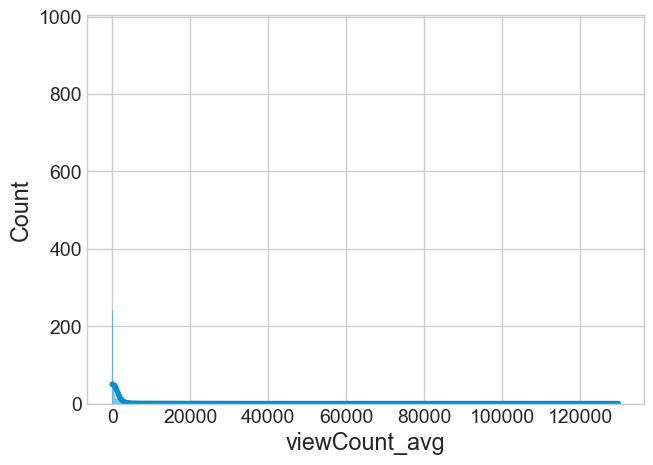

In [286]:
sns.histplot(df['viewCount_avg'], kde = True)

In [287]:
df['viewCount_avg'].describe()

count      2184.000000
mean        931.005037
std        4634.635462
min           0.000000
25%          17.000000
50%          98.500000
75%         454.250000
max      129726.000000
Name: viewCount_avg, dtype: float64

<Axes: xlabel='viewCount_avg', ylabel='Count'>

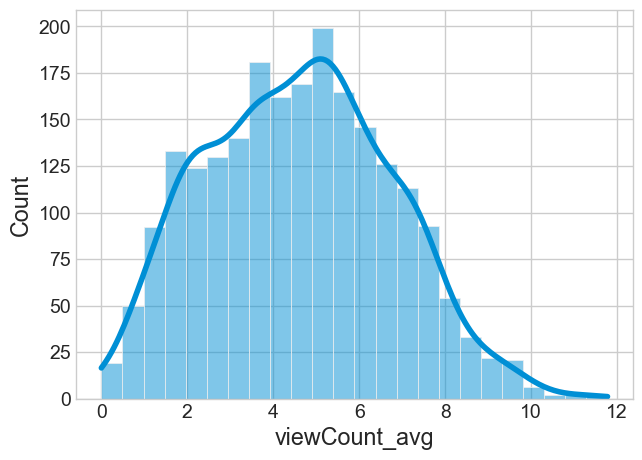

In [288]:
# 표준편차가 너무 크고 좌편향되어 있으므로 로그를 취해서 분포를 확인하겠음

sns.histplot(df['viewCount_avg'].apply(np.log1p), kde = True)

In [289]:
df['viewCount_avg'].apply(np.log1p).describe()

count    2184.000000
mean        4.587872
std         2.154023
min         0.000000
25%         2.890372
50%         4.600145
75%         6.120846
max        11.773188
Name: viewCount_avg, dtype: float64

In [290]:
# 일평균 조회수 컬럼도 로그변환하여 다른 변수와의 상관관계를 따지기로 하였음

df['viewCount_avg_log'] = df['viewCount_avg'].apply(np.log1p)

## [2] 일 평균 조회수와 프리티스케일 점수 사이의 상관관계 분석

In [293]:
# 프리티스케일 컬럼 평균점수를 기준으로 평균 이상, 이하를 구분하기 위한 새로운 컬럼 추가

df['prettyScale_updown'] = df['prettyScale'] >= df['prettyScale'].mean()

In [294]:
df['prettyScale_updown'].value_counts()

prettyScale_updown
True     1180
False    1004
Name: count, dtype: int64

/var/folders/58/1kqz1nb13r3_qtkz3d9bbjfr0000gn/T/ipykernel_43081/1723990646.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


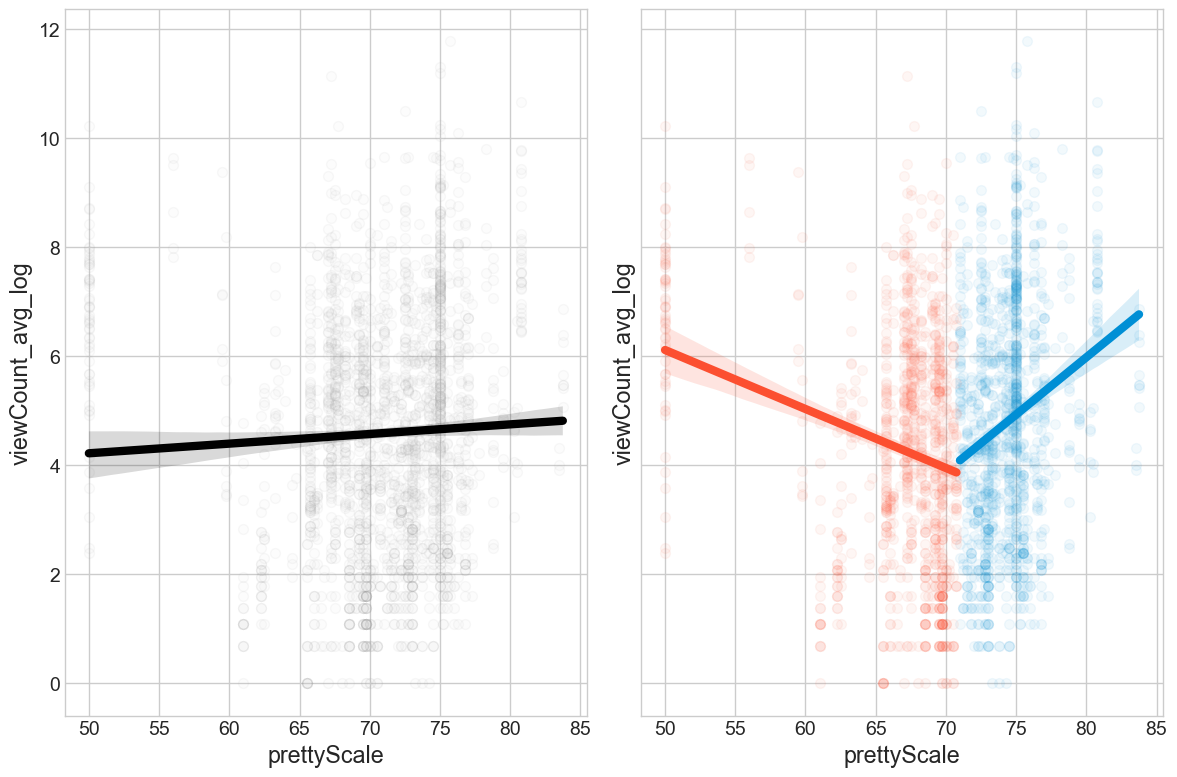

In [296]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 8), constrained_layout=True, 
                        sharex=True, sharey=True)

# 전체 데이터
sns.regplot(x="prettyScale", 
            y='viewCount_avg_log', 
            data=df, 
            label='All',
            color="k",
            scatter_kws={"s":50, "alpha":0.05, "fc":"lightgray", "ec":"gray"},
            ax = axs[0])

# 프리티스케일 평균이상
df_s = df.loc[df["prettyScale_updown"] == True]
sns.regplot(x="prettyScale", 
            y='viewCount_avg_log', 
            data=df_s, 
            label='T',
            scatter_kws={"s":50, "alpha":0.05},
            ax = axs[1])

# 프리티스케일 평균이하
df_s = df.loc[df["prettyScale_updown"] == False]
sns.regplot(x="prettyScale", 
            y='viewCount_avg_log', 
            data=df_s, 
            label='F',
            scatter_kws={"s":50, "alpha":0.05},
            ax = axs[1])

plt.tight_layout()
plt.savefig("pretty.png")
plt.show()

## [3] 일 평균 조회수와 bday 사이의 상관관계 분석

In [157]:
df.columns

Index(['channelId', 'channelTitle', 'videoId', 'duration', 'viewCount',
       'paidBadge', 'bday', 'subs', 'gender', 'prettyScale', 'publishedAt',
       'videoTitle', 'desc', 'tag', 'viewCount_log', 'subs_log',
       'viewCount_avg', 'viewCount_avg_log', 'prettyScale_updown'],
      dtype='object')

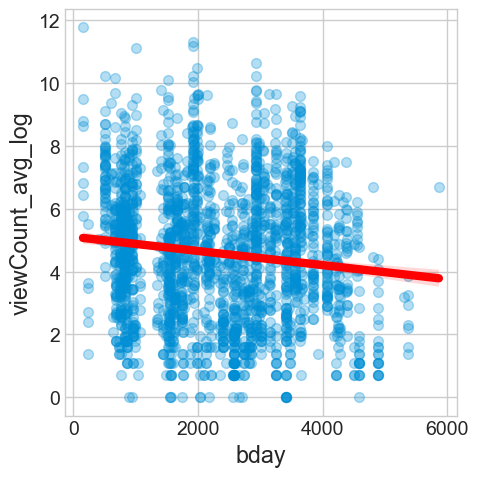

In [292]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize = (5, 5))

sns.regplot(data = df,
           x = 'bday',
           y = 'viewCount_avg_log',
           line_kws=dict(color="r"),
           scatter_kws={"s":50, "alpha":0.3})
plt.tight_layout()
plt.show()

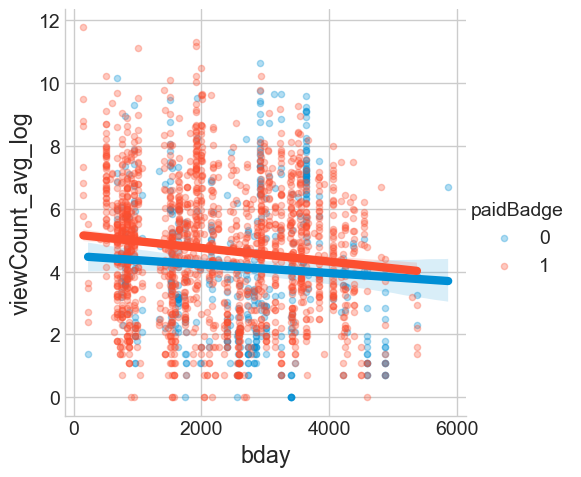

In [298]:
sns.lmplot(
    data = df,
    x = "bday",
    y = "viewCount_avg_log",
    hue = "paidBadge",
    height = 5,
    scatter_kws={'s':20,'alpha':0.3}
)

In [299]:
(df['bday'] <= 1055).value_counts()

bday
False    1673
True      511
Name: count, dtype: int64

In [300]:
# 쇼츠 출시 이전, 이후 채널 구분

df['shorts_after'] = df['bday'] <= 1055

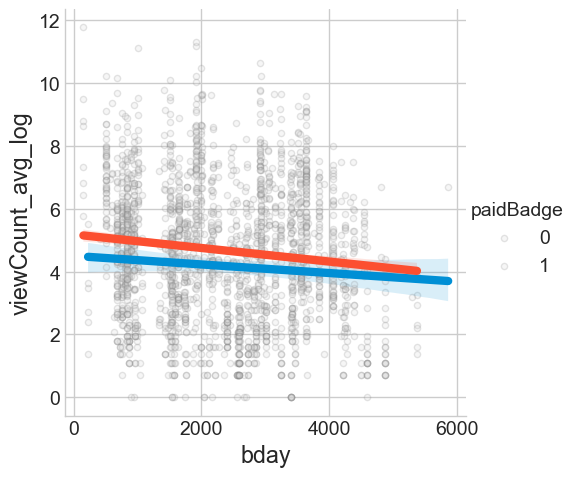

In [301]:
sns.lmplot(
    data = df,
    x = "bday",
    y = "viewCount_avg_log",
    hue = "paidBadge",
    height = 5,
    scatter_kws={'s':20,'alpha':0.2, "fc":"lightgray", "ec":"gray"},
)

<Axes: xlabel='bday', ylabel='viewCount_avg_log'>

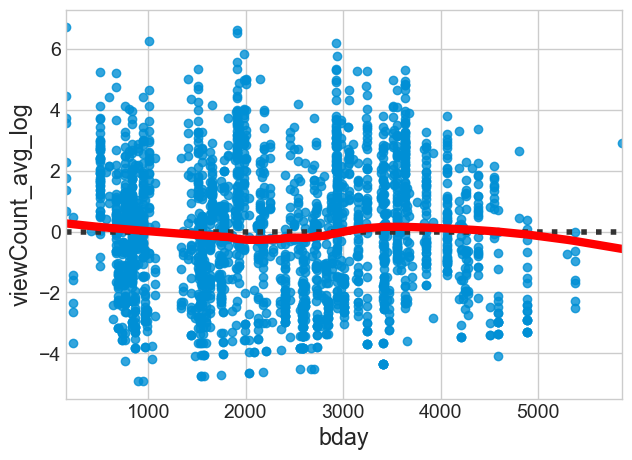

In [302]:
sns.residplot(
    data = df,
    x = "bday",
    y = "viewCount_avg_log",
    lowess=True, 
    line_kws=dict(color="r"))

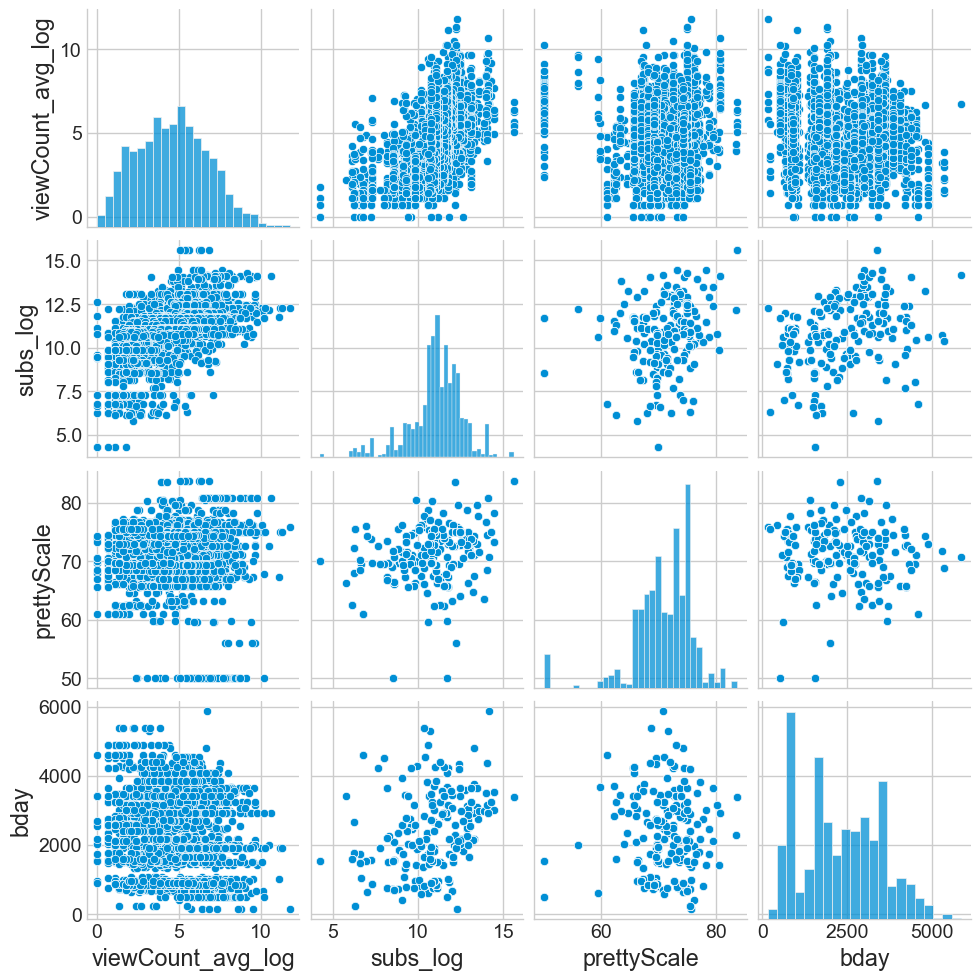

In [305]:
sns.pairplot(df[['viewCount_avg_log', 'subs_log', 'prettyScale', 'bday']],
            diag_kind="hist")

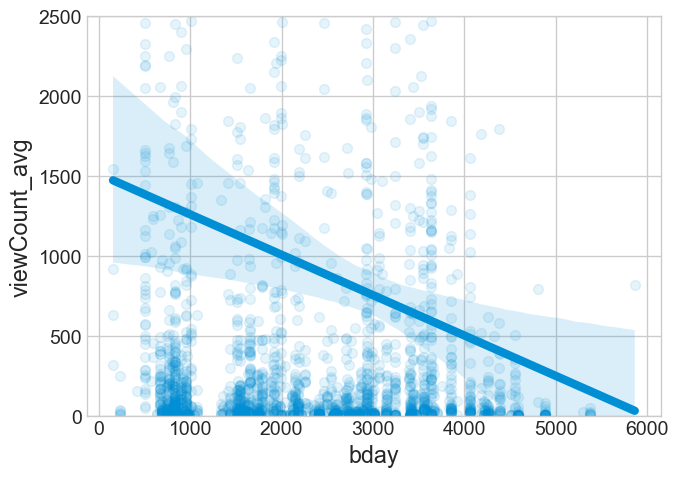

In [254]:
plt.figure(figsize = (7, 5))

sns.regplot(data = df,
            x="bday", 
            y='viewCount_avg',
            scatter_kws={"s":50, "alpha":0.1})
plt.ylim(0, 2500)
plt.tight_layout()
plt.savefig("bday.png")

In [220]:
df[df['shorts_after'] == True]['viewCount_avg'].describe()

count       510.000000
mean       1209.676471
std        6861.873861
min           0.000000
25%          36.250000
50%         167.000000
75%         535.250000
max      129726.000000
Name: viewCount_avg, dtype: float64

In [221]:
df[df['shorts_after'] == False]['viewCount_avg'].describe()

count     1674.000000
mean       846.158303
std       3697.487379
min          0.000000
25%         14.250000
50%         80.000000
75%        410.750000
max      80856.000000
Name: viewCount_avg, dtype: float64

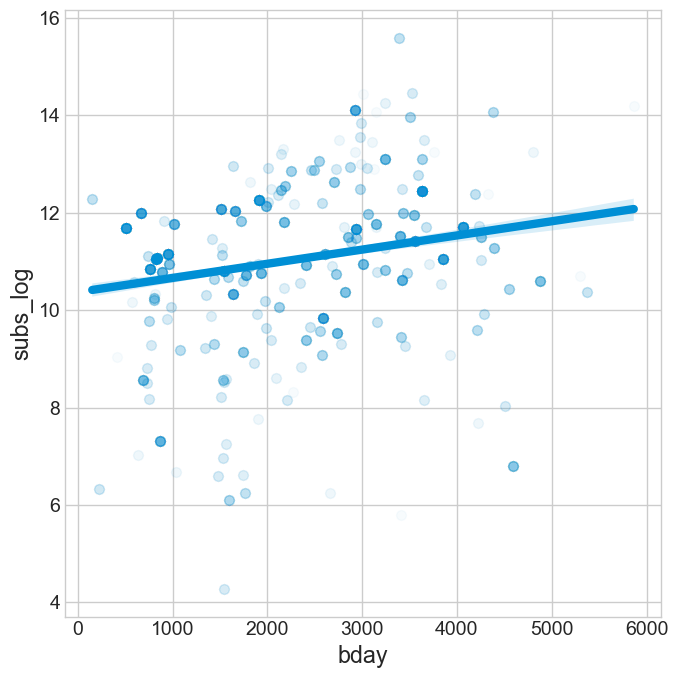

In [376]:
plt.figure(figsize = (7, 7))

sns.regplot(data = df,
            x="bday", 
            y='subs_log',
            scatter_kws={"s":50, "alpha":0.03})
plt.tight_layout()

plt.savefig("subs.png")

## [4] 청각 데이터에 뭐가 없을까.................

In [308]:
tempo['duration'].describe()

count    2184.000000
mean        0.755528
std         0.213932
min         0.000000
25%         0.600000
50%         0.800000
75%         0.945455
max         1.000000
Name: duration, dtype: float64

In [309]:
tempo['tempo'].describe()

count    2184.000000
mean        0.658702
std         0.163237
min         0.000000
25%         0.591837
50%         0.659091
75%         0.743590
max         1.000000
Name: tempo, dtype: float64

In [421]:
merged_df = pd.merge(tempo, df, on='videoId', how='inner')

In [424]:
merged_df = merged_df[['videoId', 'Mean_H', 'Mean_S', 'Mean_V', 'duration_x','duration_y', 'viewCount_avg', 'viewCount_avg_log', 'tempo', 'f0_mean', 'f0_var', 'text_rate1', 'face_area_ratio']]

In [363]:
sound = pd.read_csv("sound_final.csv")

In [367]:
sound.columns

Index(['videoId', 'Mean_H', 'Mean_S', 'Mean_V', 'channelId', 'duration',
       'viewCount', 'paidBadge', 'bday', 'subs', 'gender', 'prettyScale',
       'publishedAt', 'videoTitle', 'tag', 'viewCount_log', 'face_area_ratio',
       'face_detect', 'Smile_Value', 'text_rate1', 'minmax_text_length',
       'text_present', 'tempo', 'f0_mean', 'f0_var'],
      dtype='object')

In [425]:
merged_df = pd.merge(merged_df, sound[['videoId', 'tempo', 'f0_mean', 'f0_var']], on='videoId', how='inner')

In [426]:
merged_df.head()

,videoId,Mean_H,Mean_S,Mean_V,duration_x,duration_y,viewCount_avg,viewCount_avg_log,tempo_x,f0_mean_x,f0_var_x,text_rate1,face_area_ratio,tempo_y,f0_mean_y,f0_var_y
0,-04po9pjezs,0.620000,0.455848,0.635897,60,60,259,5.560682,0.644444,0.292685,0.377270,0.164130,0.000000,114.843750,137.814300,1321.174101
1,-0vpzxyRLwo,0.440000,0.427083,0.594872,59,59,197,5.288267,0.617021,0.520037,0.552130,0.051609,0.153501,109.956782,182.675838,1933.518669
2,-1y1r844WFA,0.200000,0.270833,0.661538,58,58,52,3.970292,0.460317,0.256817,0.307018,0.157364,0.518188,82.031250,130.736636,1075.155394
3,-3PehIzPXB0,0.786667,0.343750,0.512821,51,52,20,3.044522,0.517857,0.288907,0.351822,0.194994,0.374543,92.285156,137.068703,1232.057354
4,-3dfX3BEV6s,0.453333,0.781250,0.630769,39,41,751,6.622736,0.805556,0.529999,0.310555,0.000000,0.407089,143.554688,184.641646,1087.542731


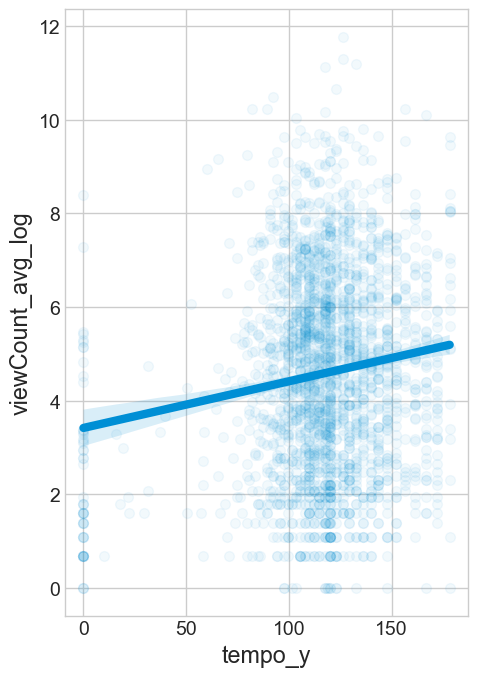

In [372]:
plt.figure(figsize = (5, 7))

sns.regplot(data = merged_df,
            x="tempo_y", 
            y='viewCount_avg_log',
            scatter_kws={"s":50, "alpha":0.05})
plt.tight_layout()
plt.savefig("tempo.png")

<Axes: xlabel='tempo_y', ylabel='viewCount_avg_log'>

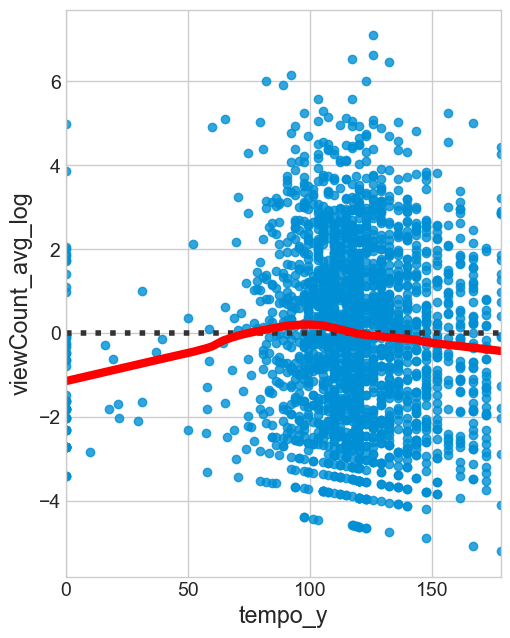

In [373]:
plt.figure(figsize = (5, 7))

sns.residplot(data = merged_df,
            x="tempo_y", 
            y='viewCount_avg_log', lowess=True, line_kws=dict(color="r"))

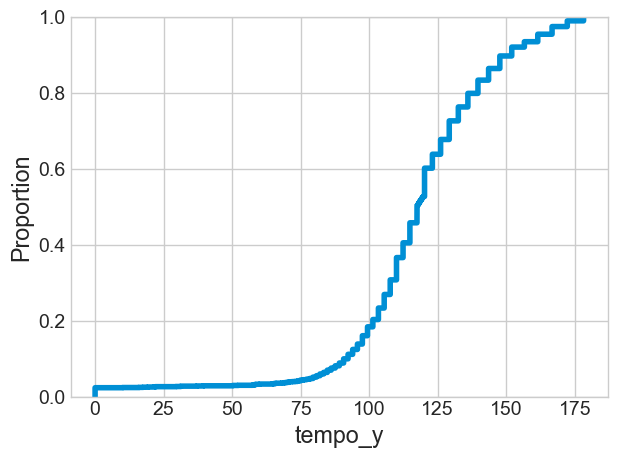

In [374]:
sns.ecdfplot(data = merged_df,
            x="tempo_y")
plt.tight_layout()
plt.savefig("tempo_proportion.png")

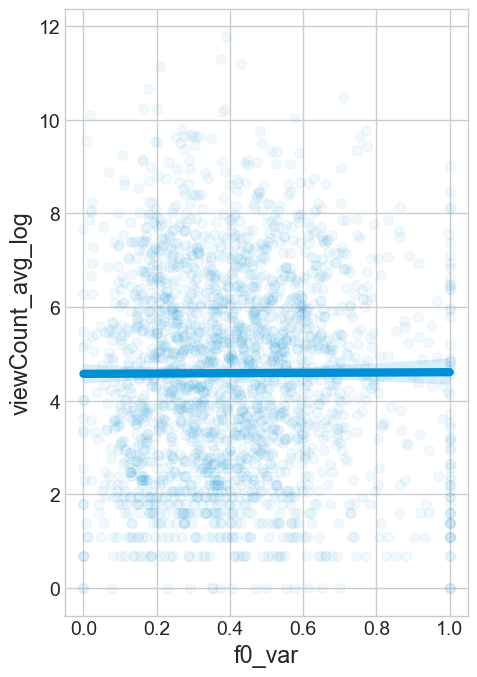

In [360]:
plt.figure(figsize = (5, 7))

sns.regplot(data = merged_df,
            x="f0_var", 
            y='viewCount_avg_log',
            scatter_kws={"s":50, "alpha":0.05})
plt.tight_layout()

In [380]:
merged_df[['tempo_y','f0_mean_y','f0_var_y', 'viewCount_avg_log']].describe()

,tempo_y,f0_mean_y,f0_var_y,viewCount_avg_log
count,2182.000000,2171.000000,2171.000000,2182.000000
mean,117.391361,145.985528,1469.930529,4.587150
std,29.102324,27.351657,875.876534,2.154150
min,0.000000,80.060925,0.000000,0.000000
25%,105.468750,124.826440,857.579396,2.890372
50%,117.453835,144.202203,1372.038035,4.600145
75%,132.512019,162.714745,1916.051768,6.119747
max,178.205819,277.383344,10340.087496,11.773188


In [382]:
import numpy as np

In [386]:
merged_df[['tempo_y','f0_mean_y','f0_var_y', 'viewCount_avg_log']].corr()

,tempo_y,f0_mean_y,f0_var_y,viewCount_avg_log
tempo_y,1.000000,-0.103462,-0.051566,0.134546
f0_mean_y,-0.103462,1.000000,0.540765,-0.028948
f0_var_y,-0.051566,0.540765,1.000000,-0.017074
viewCount_avg_log,0.134546,-0.028948,-0.017074,1.000000


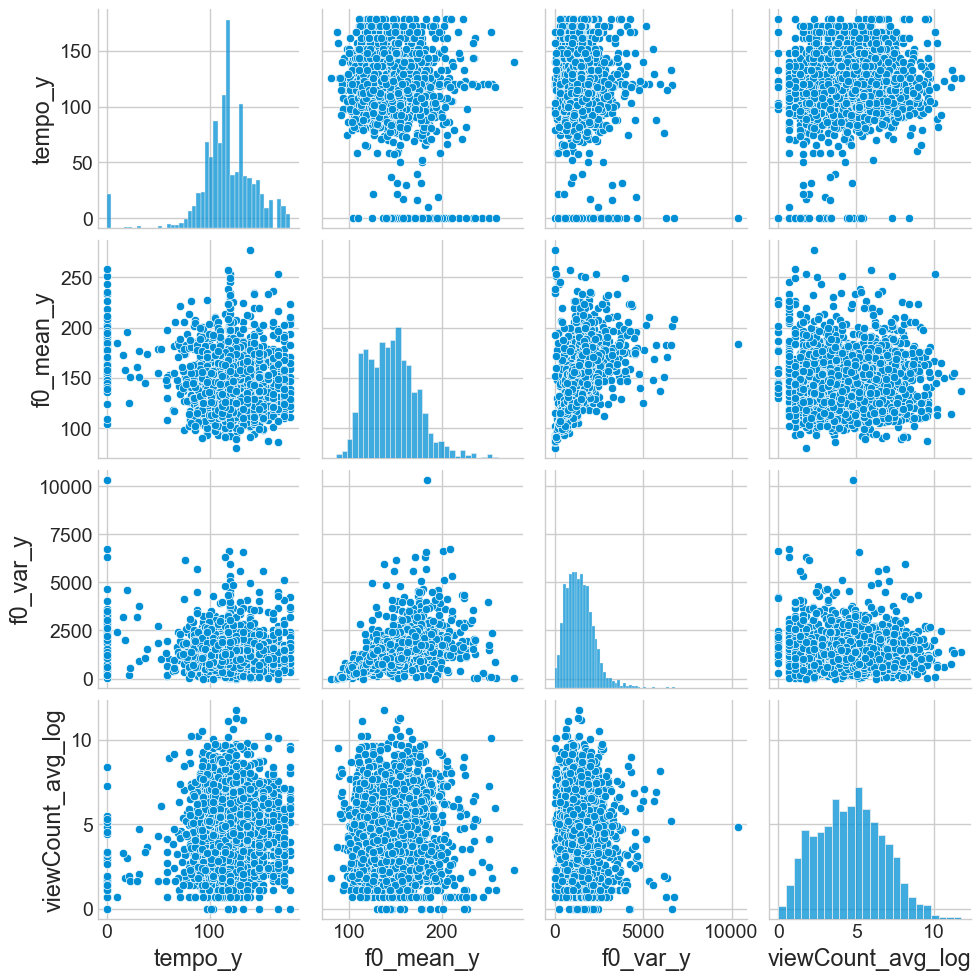

In [388]:
sns.pairplot(merged_df[['tempo_y', 'f0_mean_y', 'f0_var_y', 'viewCount_avg_log']])
plt.savefig("pair.png")

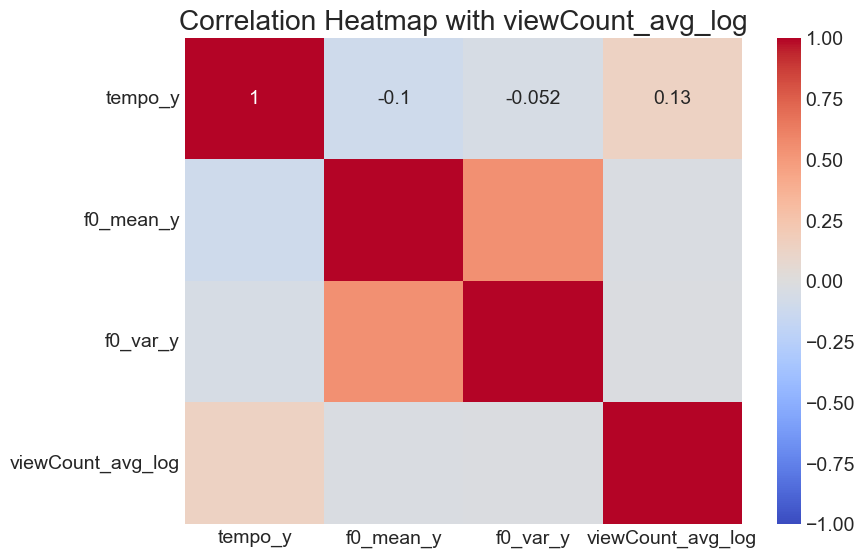

In [390]:
# Detailed Heatmap of Correlation Matrix
plt.figure(figsize=(8, 6))
corr_matrix = merged_df[['tempo_y', 'f0_mean_y', 'f0_var_y', 'viewCount_avg_log']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap with viewCount_avg_log')
plt.savefig("heatmap.png")
plt.show()

In [407]:
merged_df['tempo_y'] = merged_df['tempo_y'].apply(lambda x: 105.468750 if x <= 105 else x)

In [405]:
merged_df['tempo_y'] = merged_df['tempo_y'].apply(lambda x: 132.512019 if x >= 178 else x)

In [408]:
merged_df['tempo_y'].describe()

count    2182.000000
mean      122.417708
std        17.528890
min       105.468750
25%       105.468750
50%       117.453835
75%       132.512019
max       172.265625
Name: tempo_y, dtype: float64

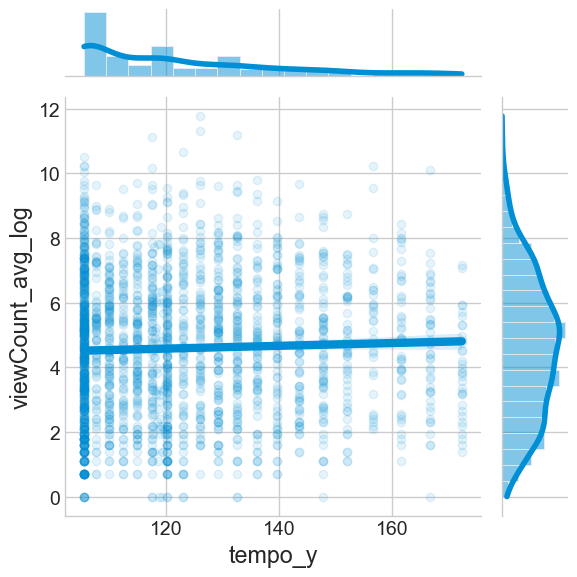

In [411]:
sns.jointplot(x=merged_df['tempo_y'], 
              y=merged_df['viewCount_avg_log'], 
              kind="reg",
              scatter_kws={'alpha':0.1})

plt.tight_layout()
plt.savefig("joint.png")

In [419]:
merged_df.drop(['videoId', 'viewCount_avg', 'tempo_y', 'f0_mean_y', 'f0_var_y'], axis = 1).corr()

,Mean_H,Mean_S,Mean_V,duration_y,viewCount_avg_log,tempo_x,f0_mean_x,f0_var_x,text_rate1,face_area_ratio
Mean_H,1.000000,-0.234569,-0.047440,-0.008345,0.048951,0.021314,0.065452,0.096654,0.072641,-0.136134
Mean_S,-0.234569,1.000000,-0.182671,-0.030272,0.073805,0.003000,0.086380,-0.016012,-0.176251,0.144587
Mean_V,-0.047440,-0.182671,1.000000,-0.067031,-0.144778,-0.082139,0.051227,0.023861,0.036908,0.110938
duration_y,-0.008345,-0.030272,-0.067031,1.000000,0.028204,0.040325,-0.130278,0.008021,0.127765,0.001725
viewCount_avg_log,0.048951,0.073805,-0.144778,0.028204,1.000000,0.134546,-0.019536,0.003542,-0.074174,0.085329
tempo_x,0.021314,0.003000,-0.082139,0.040325,0.134546,1.000000,-0.089815,-0.017571,0.002496,-0.021134
f0_mean_x,0.065452,0.086380,0.051227,-0.130278,-0.019536,-0.089815,1.000000,0.584698,-0.079012,-0.035359
f0_var_x,0.096654,-0.016012,0.023861,0.008021,0.003542,-0.017571,0.584698,1.000000,0.016748,-0.052894
text_rate1,0.072641,-0.176251,0.036908,0.127765,-0.074174,0.002496,-0.079012,0.016748,1.000000,-0.106162
face_area_ratio,-0.136134,0.144587,0.110938,0.001725,0.085329,-0.021134,-0.035359,-0.052894,-0.106162,1.000000


In [439]:
merged_df[['Mean_H', 'text_rate1', 'face_area_ratio','tempo_x', 'f0_mean_x', 'f0_var_x', 'viewCount_avg_log']].corr()

,Mean_H,text_rate1,face_area_ratio,tempo_x,f0_mean_x,f0_var_x,viewCount_avg_log
Mean_H,1.000000,0.072641,-0.136134,0.021314,0.065452,0.096654,0.048951
text_rate1,0.072641,1.000000,-0.106162,0.002496,-0.079012,0.016748,-0.074174
face_area_ratio,-0.136134,-0.106162,1.000000,-0.021134,-0.035359,-0.052894,0.085329
tempo_x,0.021314,0.002496,-0.021134,1.000000,-0.089815,-0.017571,0.134546
f0_mean_x,0.065452,-0.079012,-0.035359,-0.089815,1.000000,0.584698,-0.019536
f0_var_x,0.096654,0.016748,-0.052894,-0.017571,0.584698,1.000000,0.003542
viewCount_avg_log,0.048951,-0.074174,0.085329,0.134546,-0.019536,0.003542,1.000000


In [441]:
merged_df.drop('videoId', axis = 1).corr()

,Mean_H,Mean_S,Mean_V,duration_x,duration_y,viewCount_avg,viewCount_avg_log,tempo_x,f0_mean_x,f0_var_x,text_rate1,face_area_ratio,tempo_y,f0_mean_y,f0_var_y
Mean_H,1.000000,-0.234569,-0.047440,-0.008147,-0.008345,-0.032183,0.048951,0.021314,0.065452,0.096654,0.072641,-0.136134,0.021314,0.057497,0.067429
Mean_S,-0.234569,1.000000,-0.182671,-0.030053,-0.030272,-0.017012,0.073805,0.003000,0.086380,-0.016012,-0.176251,0.144587,0.003000,0.089500,-0.000256
Mean_V,-0.047440,-0.182671,1.000000,-0.067300,-0.067031,-0.043874,-0.144778,-0.082139,0.051227,0.023861,0.036908,0.110938,-0.082139,0.060064,0.030142
duration_x,-0.008147,-0.030053,-0.067300,1.000000,0.999791,-0.009963,0.028360,0.040696,-0.130006,0.008576,0.127728,0.001980,0.040696,-0.130139,0.000166
duration_y,-0.008345,-0.030272,-0.067031,0.999791,1.000000,-0.010187,0.028204,0.040325,-0.130278,0.008021,0.127765,0.001725,0.040325,-0.130336,-0.000313
viewCount_avg,-0.032183,-0.017012,-0.043874,-0.009963,-0.010187,1.000000,0.397415,0.023454,0.001340,-0.020653,-0.025297,0.073653,0.023454,-0.000452,-0.022415
viewCount_avg_log,0.048951,0.073805,-0.144778,0.028360,0.028204,0.397415,1.000000,0.134546,-0.019536,0.003542,-0.074174,0.085329,0.134546,-0.028948,-0.017074
tempo_x,0.021314,0.003000,-0.082139,0.040696,0.040325,0.023454,0.134546,1.000000,-0.089815,-0.017571,0.002496,-0.021134,1.000000,-0.103462,-0.051566
f0_mean_x,0.065452,0.086380,0.051227,-0.130006,-0.130278,0.001340,-0.019536,-0.089815,1.000000,0.584698,-0.079012,-0.035359,-0.089815,1.000000,0.540765
f0_var_x,0.096654,-0.016012,0.023861,0.008576,0.008021,-0.020653,0.003542,-0.017571,0.584698,1.000000,0.016748,-0.052894,-0.017571,0.575565,0.959544


In [442]:
final = pd.read_csv('real_final.csv')

In [446]:
final.drop(['videoId', 'channelId'], axis = 1).corr().to_csv('corr.csv')

In [447]:
final.drop(['videoId', 'channelId'], axis = 1).corr()

,Mean_H,Mean_S,Mean_V,duration,viewCount,paidBadge,bday,subs,gender,prettyScale,...,viewCount_log,face_area_ratio,face_detect,Smile_Value,text_rate1,minmax_text_length,text_present,tempo,f0_mean,f0_var
Mean_H,1.000000,-0.234792,-0.047873,-0.007127,-0.003428,0.027743,-0.044329,0.089595,0.115499,0.161564,...,0.040748,-0.134822,0.031010,0.086021,0.071703,-0.012314,0.064757,0.021450,0.063508,0.097714
Mean_S,-0.234792,1.000000,-0.182423,-0.030739,0.040120,-0.036027,-0.024317,0.010294,0.087771,-0.089915,...,0.123583,0.144502,-0.008063,-0.033074,-0.176176,0.008034,-0.123071,0.002767,0.086706,-0.017154
Mean_V,-0.047873,-0.182423,1.000000,-0.067482,0.011524,-0.092315,0.094665,-0.061897,0.037221,-0.150567,...,-0.097302,0.110337,-0.240738,-0.101048,0.037272,0.122783,0.055504,-0.082180,0.051911,0.023375
duration,-0.007127,-0.030739,-0.067482,1.000000,-0.060388,0.026333,0.048887,0.054128,-0.063953,0.120800,...,0.019977,0.002940,0.077469,0.102494,0.126690,-0.010554,0.095205,0.040458,-0.131950,0.009313
viewCount,-0.003428,0.040120,0.011524,-0.060388,1.000000,-0.114609,0.018538,0.211644,-0.001107,0.069146,...,0.408509,0.045549,0.030902,0.011757,-0.074977,-0.036724,-0.115299,0.029768,0.024435,0.002402
paidBadge,0.027743,-0.036027,-0.092315,0.026333,-0.114609,1.000000,-0.144978,0.078855,-0.115318,-0.070946,...,0.056215,-0.038032,0.102092,0.148736,0.078312,-0.070934,0.177964,0.054550,-0.111693,0.003204
bday,-0.044329,-0.024317,0.094665,0.048887,0.018538,-0.144978,1.000000,0.215614,0.052722,0.120633,...,-0.075232,0.014449,-0.060615,-0.107744,-0.026195,0.031544,-0.149724,-0.084693,0.048753,0.056869
subs,0.089595,0.010294,-0.061897,0.054128,0.211644,0.078855,0.215614,1.000000,0.170252,0.206366,...,0.613455,0.099457,0.156048,0.082013,-0.067739,-0.163370,-0.132025,0.044530,0.006278,0.058412
gender,0.115499,0.087771,0.037221,-0.063953,-0.001107,-0.115318,0.052722,0.170252,1.000000,0.038693,...,0.054079,0.053168,-0.102196,0.027334,-0.039255,0.030255,-0.071976,-0.024006,0.282775,0.198522
prettyScale,0.161564,-0.089915,-0.150567,0.120800,0.069146,-0.070946,0.120633,0.206366,0.038693,1.000000,...,0.028826,-0.027540,0.162053,-0.020320,-0.007832,-0.088936,-0.153453,0.013692,0.159222,0.122868


<Axes: xlabel='f0_mean', ylabel='Count'>

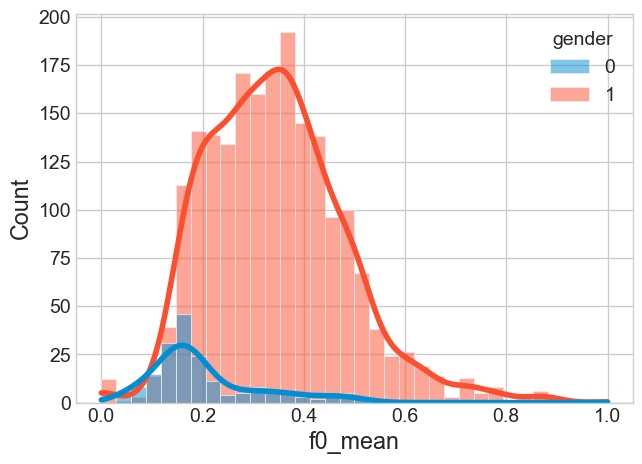

In [453]:
sns.histplot(data = final,
            x = 'f0_mean',
           hue = 'gender',
            kde = True)

<Axes: xlabel='f0_mean', ylabel='viewCount_log'>

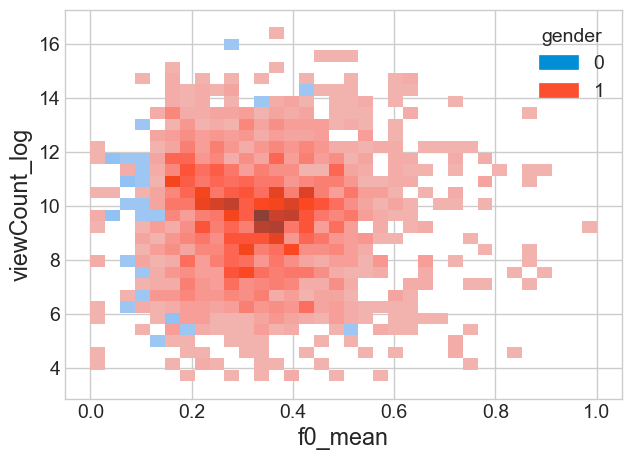

In [454]:
sns.histplot(data = final,
            x = 'f0_mean',
             y = 'viewCount_log',
           hue = 'gender',
            kde = True)

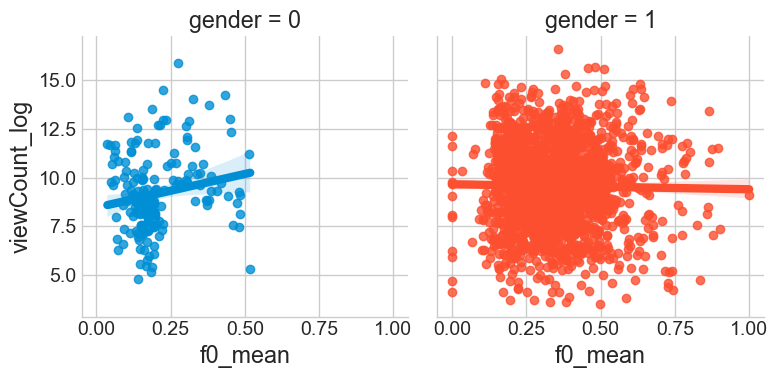

In [456]:
sns.lmplot(
    data=final,
            x = 'f0_mean',
             y = 'viewCount_log',
    hue="gender", 
    col = 'gender',
    height=4,
)

In [459]:
tempo

,videoId,Mean_H,Mean_S,Mean_V,channelId,duration,viewCount,paidBadge,bday,subs,...,viewCount_log,face_area_ratio,face_detect,Smile_Value,text_rate1,minmax_text_length,text_present,tempo,f0_mean,f0_var
0,-04po9pjezs,0.620000,0.455848,0.635897,UCKxsnH8o2fymQDymR0-5MNw,60,6227,1,0.615896,0.656151,...,8.736811,0.000000,0,0,0.164130,0.076923,1.0,0.644444,0.292685,0.377270
1,-0vpzxyRLwo,0.440000,0.427083,0.594872,UCDhEQ2-xLDnWaog9w0CXiLQ,59,41110,1,0.106968,0.580856,...,10.624031,0.153501,1,1,0.051609,0.076923,1.0,0.617021,0.520037,0.552130
2,-1y1r844WFA,0.200000,0.270833,0.661538,UCO39RtFb8lh2r1THMeXBsZg,58,9199,1,0.353817,0.665824,...,9.126959,0.518188,1,1,0.157364,0.038462,1.0,0.460317,0.256817,0.307018
3,-3PehIzPXB0,0.786667,0.343750,0.512821,UCdAL9PEu4pHWvsSZMhVto6A,51,674,0,0.394783,0.451256,...,6.514713,0.374543,1,0,0.194994,0.038462,1.0,0.517857,0.288907,0.351822
4,-3dfX3BEV6s,0.453333,0.781250,0.630769,UCn_fZLXut_Tj9-QihG_9l0g,39,305786,0,0.484769,0.869252,...,12.630644,0.407089,1,0,0.000000,0.000000,0.0,0.805556,0.529999,0.310555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,mr0SMDSNku0,0.833333,0.229167,0.723077,UCiAzDHGJTIjlXZZKj9aErWw,60,5494,1,0.449405,0.571662,...,8.611594,0.000000,0,0,0.123395,0.192308,1.0,0.644444,0.233159,0.356968
2180,n8PWy-F3k78,0.540000,0.500000,0.579487,UC7R377JtSnWUAH3bIDX3mZw,29,15322,1,0.129552,0.574467,...,9.637110,0.199364,1,1,0.030212,0.000000,1.0,0.557692,0.281847,0.219769
2181,rtMAIUFMGKI,0.040000,0.927083,0.430769,UClAWUThX9ZzVi0v3kZiDqfg,50,1252,1,0.580532,0.573727,...,7.133296,0.440999,1,0,0.062163,0.000000,1.0,0.674419,0.387549,0.861912
2182,setBKVc7DfI,0.193333,0.427083,0.805128,UCiAzDHGJTIjlXZZKj9aErWw,59,1225,1,0.449405,0.571662,...,7.111512,0.193261,1,1,0.099481,0.000000,1.0,0.547170,0.333119,0.693628


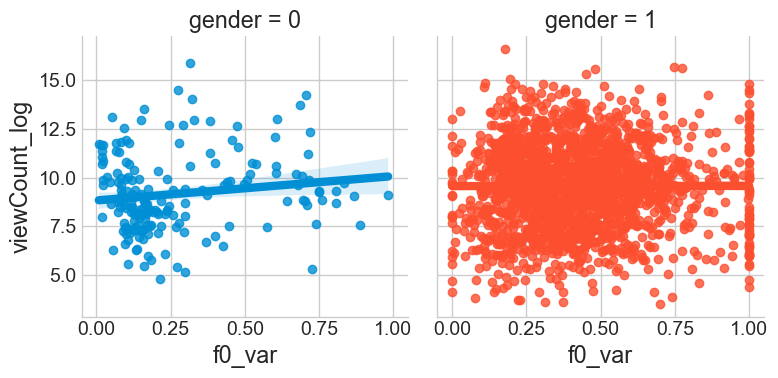

In [474]:
sns.lmplot(
    data=tempo,
            x = 'f0_var',
             y = 'viewCount_log',
    hue="gender", 
    col = 'gender',
    height=4,
)

In [478]:
merged_df[['f0_var_x', 'f0_var_y', 'viewCount_avg_log']].corr()

,f0_var_x,f0_var_y,viewCount_avg_log
f0_var_x,1.000000,0.959544,0.003542
f0_var_y,0.959544,1.000000,-0.017074
viewCount_avg_log,0.003542,-0.017074,1.000000


In [480]:
merged_df[['f0_var_y', 'viewCount_avg_log', 'viewCount_avg']]

,f0_var_y,viewCount_avg_log,viewCount_avg
0,1321.174101,5.560682,259
1,1933.518669,5.288267,197
2,1075.155394,3.970292,52
3,1232.057354,3.044522,20
4,1087.542731,6.622736,751
...,...,...,...
2177,1250.076360,3.367296,28
2178,769.615207,5.187386,178
2179,3018.354870,1.609438,4
2180,2429.035209,3.295837,26


array([[<Axes: title={'center': 'f0_var_y'}>]], dtype=object)

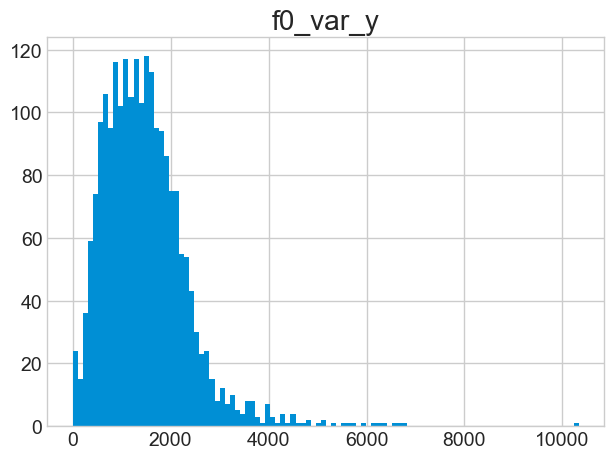

In [483]:
merged_df[['f0_var_y']].hist(bins = 100)